In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

import numpy as np
import polars as pl
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

# Inspiread by sns palletes: 'CMRmap', 'Set1', 'tab20'

# Define golden ratio for height1
golden_ratio = (5**0.5 - 1) / 2  # ≈ 0.618
FIG_WIDTH_IN = 170 / 25.4  # matches typical \linewidth in 12pt LaTeX article
FIG_HEIGHT_IN = FIG_WIDTH_IN * golden_ratio  # aesthetically pleasing height
SUPTITLE_FONTSIZE = 12
plt.rcParams.update(
    {
        # === Font settings ===
        # 'text.usetex': True,
        "font.family": "serif",
        "font.size": 8,  # Base font size
        "axes.labelsize": 8,  # Axis label font
        "axes.titlesize": 12,  # Title font size
        "xtick.labelsize": 8,  # X tick labels
        "ytick.labelsize": 8,  # Y tick labels
        "legend.fontsize": 8,  # Legend text size
        # === Figure settings ===
        "figure.figsize": (FIG_WIDTH_IN, FIG_HEIGHT_IN),  # Size in inches
        "figure.dpi": 300,  # High-res for export
        # === Line/Marker settings ===
        "lines.linewidth": 1.5,
        "lines.markersize": 4,
        # === Grid and style ===
        "axes.grid": True,
        "grid.alpha": 0.4,
        "grid.linestyle": "--",
        # === Legend settings ===
        # 'legend.frameon': False,        # No frame (border)
        # 'legend.facecolor': 'none',     # Transparent background
        "legend.edgecolor": "none",  # No edge line (just in case)
        # === Save options ===
        "savefig.format": "svg",
        "savefig.bbox": "tight",  # Avoid extra whitespace
        "savefig.dpi": 300,  # High-res for export
    }
)
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#984ea3",
        "#ff7f0e",
        "#1f77b4",
        "#e41a1c",
        "#4daf4a",
        "#ffff3e",
        "#f781bf",
        "#999999",
    ]
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

OUPUT_PATH = Path("../latex/imgs/res/")
OUPUT_PATH.mkdir(parents=True, exist_ok=True)
OUPUT_TABLES_PATH = Path("../latex/tables/")
OUPUT_TABLES_PATH.mkdir(parents=True, exist_ok=True)
DATA_OUTPUT_PATH = Path("../data/results/")
DATA_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

DUOPOLY_OUPUT_PATH = Path(OUPUT_PATH) / "duopoly"
DUOPOLY_OUPUT_PATH.mkdir(parents=True, exist_ok=True)

In [2]:
df = pl.read_parquet(DATA_OUTPUT_PATH / "all_experiments.parquet").filter(
    (pl.col("num_agents") > 1) & (pl.col("is_symmetric"))
)

# Duopoly
---

In [3]:
df_2 = df.filter(pl.col("num_agents") == 2)
p_m = df_2.select(pl.col("monopoly_prices")).min().to_series().to_list()[0]
q_m = df_2.select(pl.col("monopoly_quantities")).min().to_series().to_list()[0]
pi_m = df_2.select(pl.col("monopoly_profits")).min().to_series().to_list()[0]

p_nash = df_2.select(pl.col("nash_prices")).min().to_series().to_list()[0]
pi_nash = df_2.select(pl.col("nash_profits")).min().to_series().to_list()[0]
p_m, q_m, pi_m, p_nash, pi_nash

(1.9249809226802002,
 36.48620214955832,
 33.74904595088663,
 1.4729287006070746,
 22.29266581242071)

In [4]:
df_2 = (
    df_2.filter(pl.col("round") > 250)
    .with_columns((pl.col("chosen_price") / pl.col("alpha")).alias("price_normalized"))
    .pivot(
        index=["experiment_timestamp", "agent_prefix_type", "round"],
        on="agent",
        values=["price_normalized"],
    )
    .group_by(
        [
            "experiment_timestamp",
            "agent_prefix_type",
        ]
    )
    .agg(
        (
            pl.col("Firm A").mean().round(2).alias("Firm A"),
            (pl.col("Firm B").mean().round(2).alias("Firm B")),
        )
    )
    .sort("agent_prefix_type")
)
df_2

experiment_timestamp,agent_prefix_type,Firm A,Firm B
str,str,f64,f64
"""1751084558""","""P1""",2.01,2.1
"""1751088827""","""P1""",2.05,2.06
"""1751045680""","""P1""",1.97,1.75
"""1751052703""","""P1""",1.71,2.03
"""1751063208""","""P1""",1.85,1.84
…,…,…,…
"""1751082381""","""P2""",1.46,1.46
"""1751070134""","""P2""",1.59,1.61
"""1751043229""","""P2""",1.43,1.46


In [5]:
def plot_duopoly_jointplot(df, p_m, p_nash, title, save_path):
    # Create the jointplot
    g = sns.jointplot(
        data=df,
        x="Firm A",
        y="Firm B",
        hue="agent_prefix_type",
        xlim=(1.25, 2.4),
        ylim=(1.25, 2.4),
        alpha=1,
        height=5,  # Adjust this to control overall size
        ratio=4,  # Controls marginal plot size
    )

    # Add vertical and horizontal lines to the joint (central) axes
    g.ax_joint.axvline(x=p_m, linestyle="--", label="$P^{Monopoly}$", color=colors[0])
    g.ax_joint.axvline(x=p_nash, linestyle="--", label="$P^{Nash}$", color=colors[1])
    g.ax_joint.axhline(y=p_m, linestyle="--", color=colors[0])
    g.ax_joint.axhline(y=p_nash, linestyle="--", color=colors[1])

    # Combine legends: get handles from scatter and lines
    handles_scatter, labels_scatter = g.ax_joint.get_legend_handles_labels()
    line_handles, line_labels = g.ax_joint.get_legend_handles_labels()

    # Remove default legend (inside the plot)
    if g.ax_joint.legend_:
        g.ax_joint.legend_.remove()

    g.figure.legend(
        handles_scatter,
        labels_scatter,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=4,
    )

    # Title for the entire figure
    g.figure.suptitle(title, fontsize=SUPTITLE_FONTSIZE)
    g.figure.tight_layout()
    g.ax_joint.set_xlabel("Firm A average price (last 50 rounds)")
    g.ax_joint.set_ylabel("Firm B average price (last 50 rounds)")
    plt.savefig(save_path.with_suffix(".svg"))
    plt.show()
    return

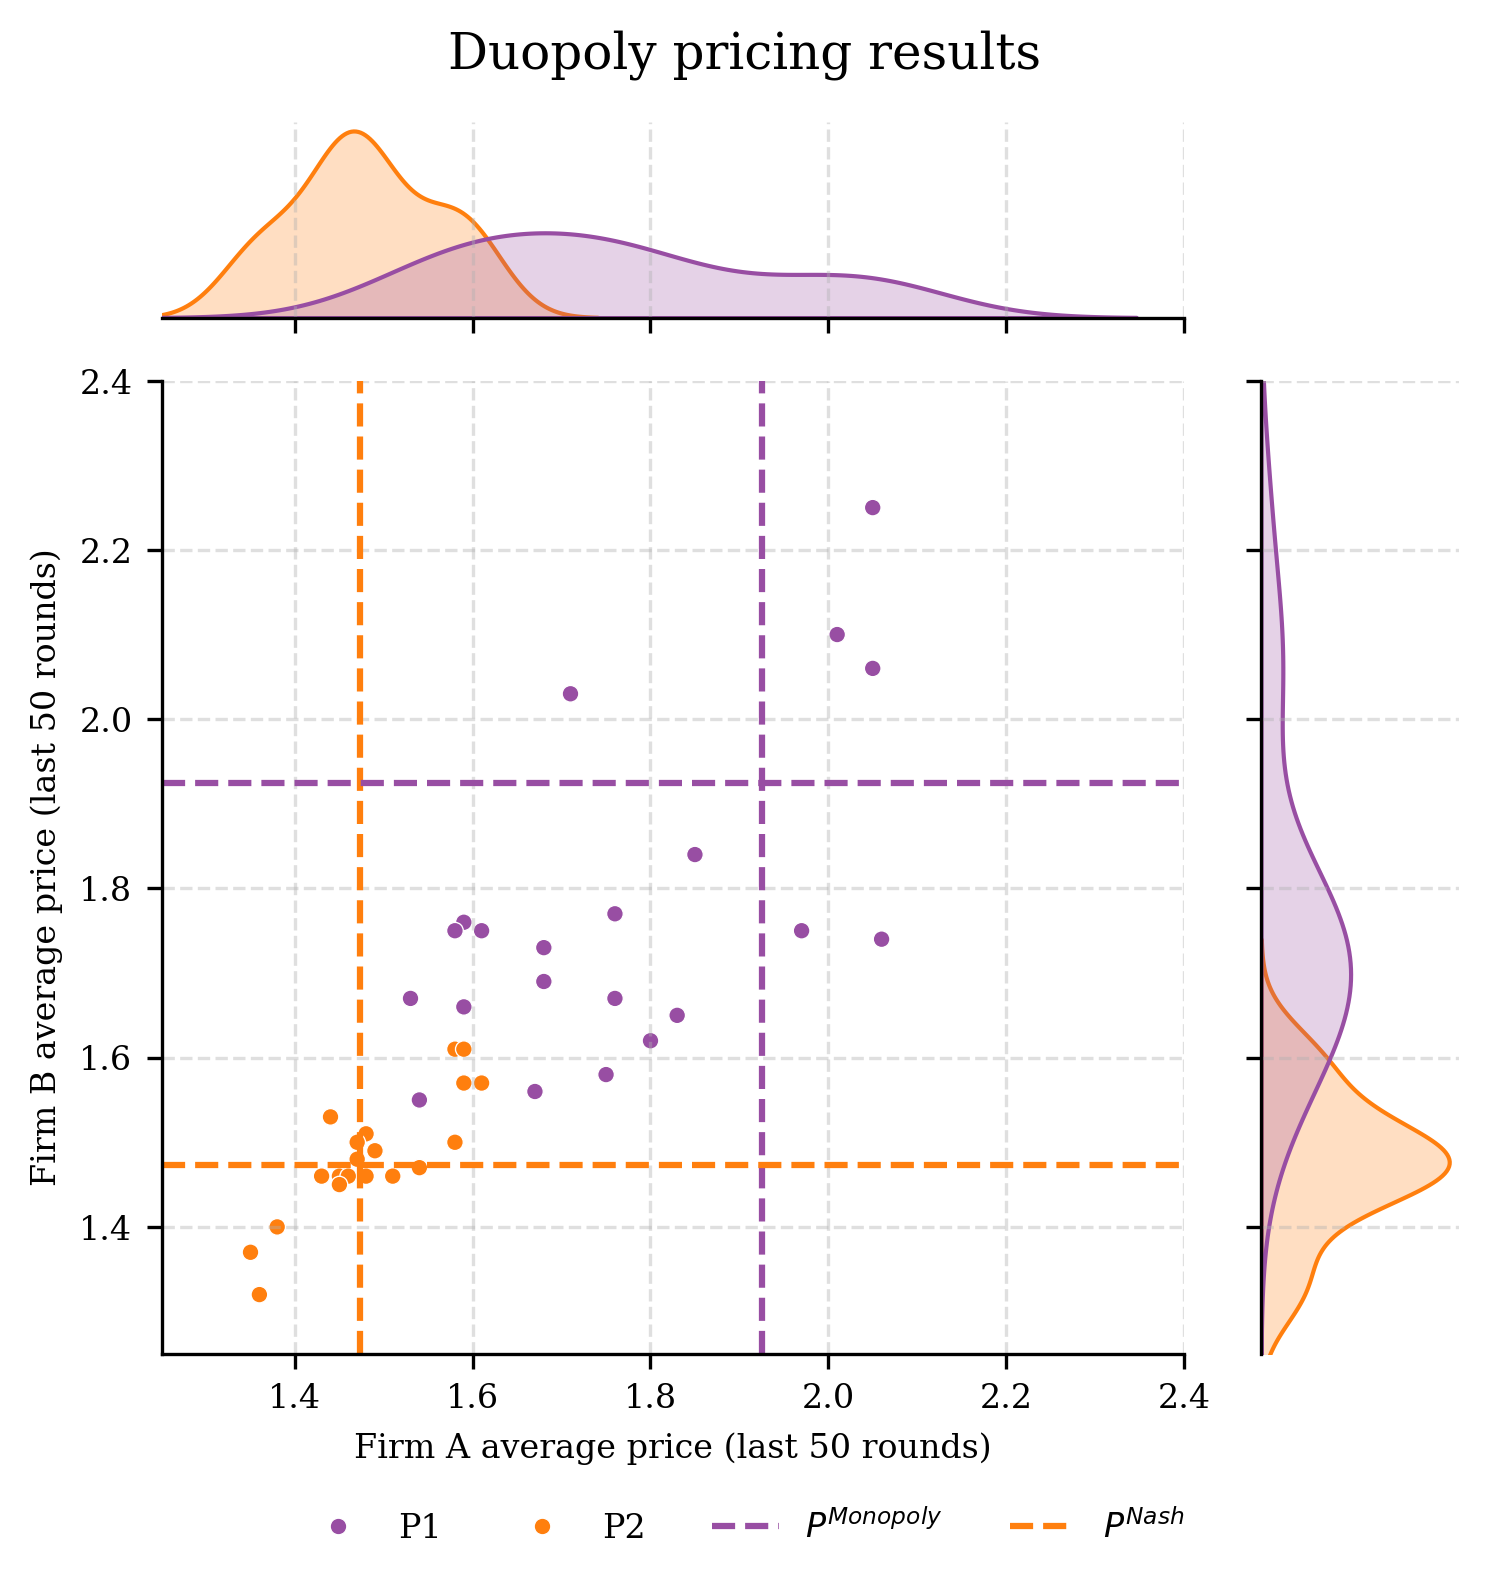

In [6]:
plot_duopoly_jointplot(
    df_2,
    p_m,
    p_nash,
    title="Duopoly pricing results",
    save_path=DUOPOLY_OUPUT_PATH / "duopoly_jointplot",
)

In [7]:
def plot_duopoly_profit_panel(
    df, pi_nash, pi_m, title="Profit Results by Prefix Type", save_path=None
):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_title(title)

    # Preprocess dataframe
    df = (
        df.filter(pl.col("round").is_between(251, 300))
        .select(
            [
                "experiment_timestamp",
                "agent",
                "agent_prefix_type",
                "alpha",
                "chosen_price",
                "profit",
            ]
        )
        .with_columns(
            (pl.col("chosen_price") / pl.col("alpha")).alias("price_normalized"),
            (pl.col("profit") / pl.col("alpha")).alias("profit_normalized"),
        )
        .group_by(["experiment_timestamp", "agent", "agent_prefix_type"])
        .agg(
            pl.col("price_normalized").mean().round(2).alias("mean_price_normalized"),
            pl.col("profit").mean().round(2).alias("profit"),
        )
        .sort(["experiment_timestamp", "agent", "agent_prefix_type"])
        .pivot(
            index=["experiment_timestamp", "agent_prefix_type"],
            on="agent",
            values=["mean_price_normalized", "profit"],
        )
        .with_columns(
            (pl.col("profit_Firm A") - pl.col("profit_Firm B")).alias("pi_delta"),
            (pl.col("profit_Firm A") + pl.col("profit_Firm B")).alias("pi_sum"),
        )
    )

    # Diagonal lines for π₁ = π^{Nash} and π₂ = π^{Nash}
    y_vals = np.linspace(2 * pi_nash, 2 * pi_m, 200)
    delta_1 = 2 * pi_nash - y_vals
    delta_2 = y_vals - 2 * pi_nash

    ax.plot(delta_1, y_vals, ":", color="black", label=None)
    ax.plot(delta_2, y_vals, ":", color="black", label=None)

    # Scatter points by prefix type
    ax.scatter(
        df.filter(pl.col("agent_prefix_type") == "P1").select("pi_delta"),
        df.filter(pl.col("agent_prefix_type") == "P1").select("pi_sum"),
        color=colors[0],
        marker="o",
        label="P1",
    )
    ax.scatter(
        df.filter(pl.col("agent_prefix_type") == "P2").select("pi_delta"),
        df.filter(pl.col("agent_prefix_type") == "P2").select("pi_sum"),
        color=colors[1],
        marker="o",
        label="P2",
    )
    # set ax xlim
    ax.set_xlim(-47, 47)

    # Monopoly profit line
    ax.axhline(2 * pi_m, color=colors[0], linestyle="--", linewidth=1, alpha=0.8)
    ax.text(
        df["pi_delta"].min() * 1.05, 2 * pi_m, r"$\pi^M$", color=colors[0], va="bottom"
    )

    # Labels
    ax.set_xlabel(r"Average difference in profits $\pi_1 - \pi_2$ (last 50 rounds)")
    ax.set_ylabel(r"Average sum of profits $\pi_1 + \pi_2$ (last 50 rounds)")
    # Annotations
    ax.text(
        np.mean(delta_1) * 2,
        (2.2 * pi_nash),
        r"$\pi_1 = \pi^{Nash}$",
        color="black",
        fontsize=10,
    )
    ax.text(
        np.mean(delta_2),
        (2.2 * pi_nash),
        r"$\pi_2 = \pi^{Nash}$",
        color="black",
        fontsize=10,
    )
    # Legend outside below in 4 columns
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=2,
    )
    # Legend
    # ax.legend(loc="best")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()

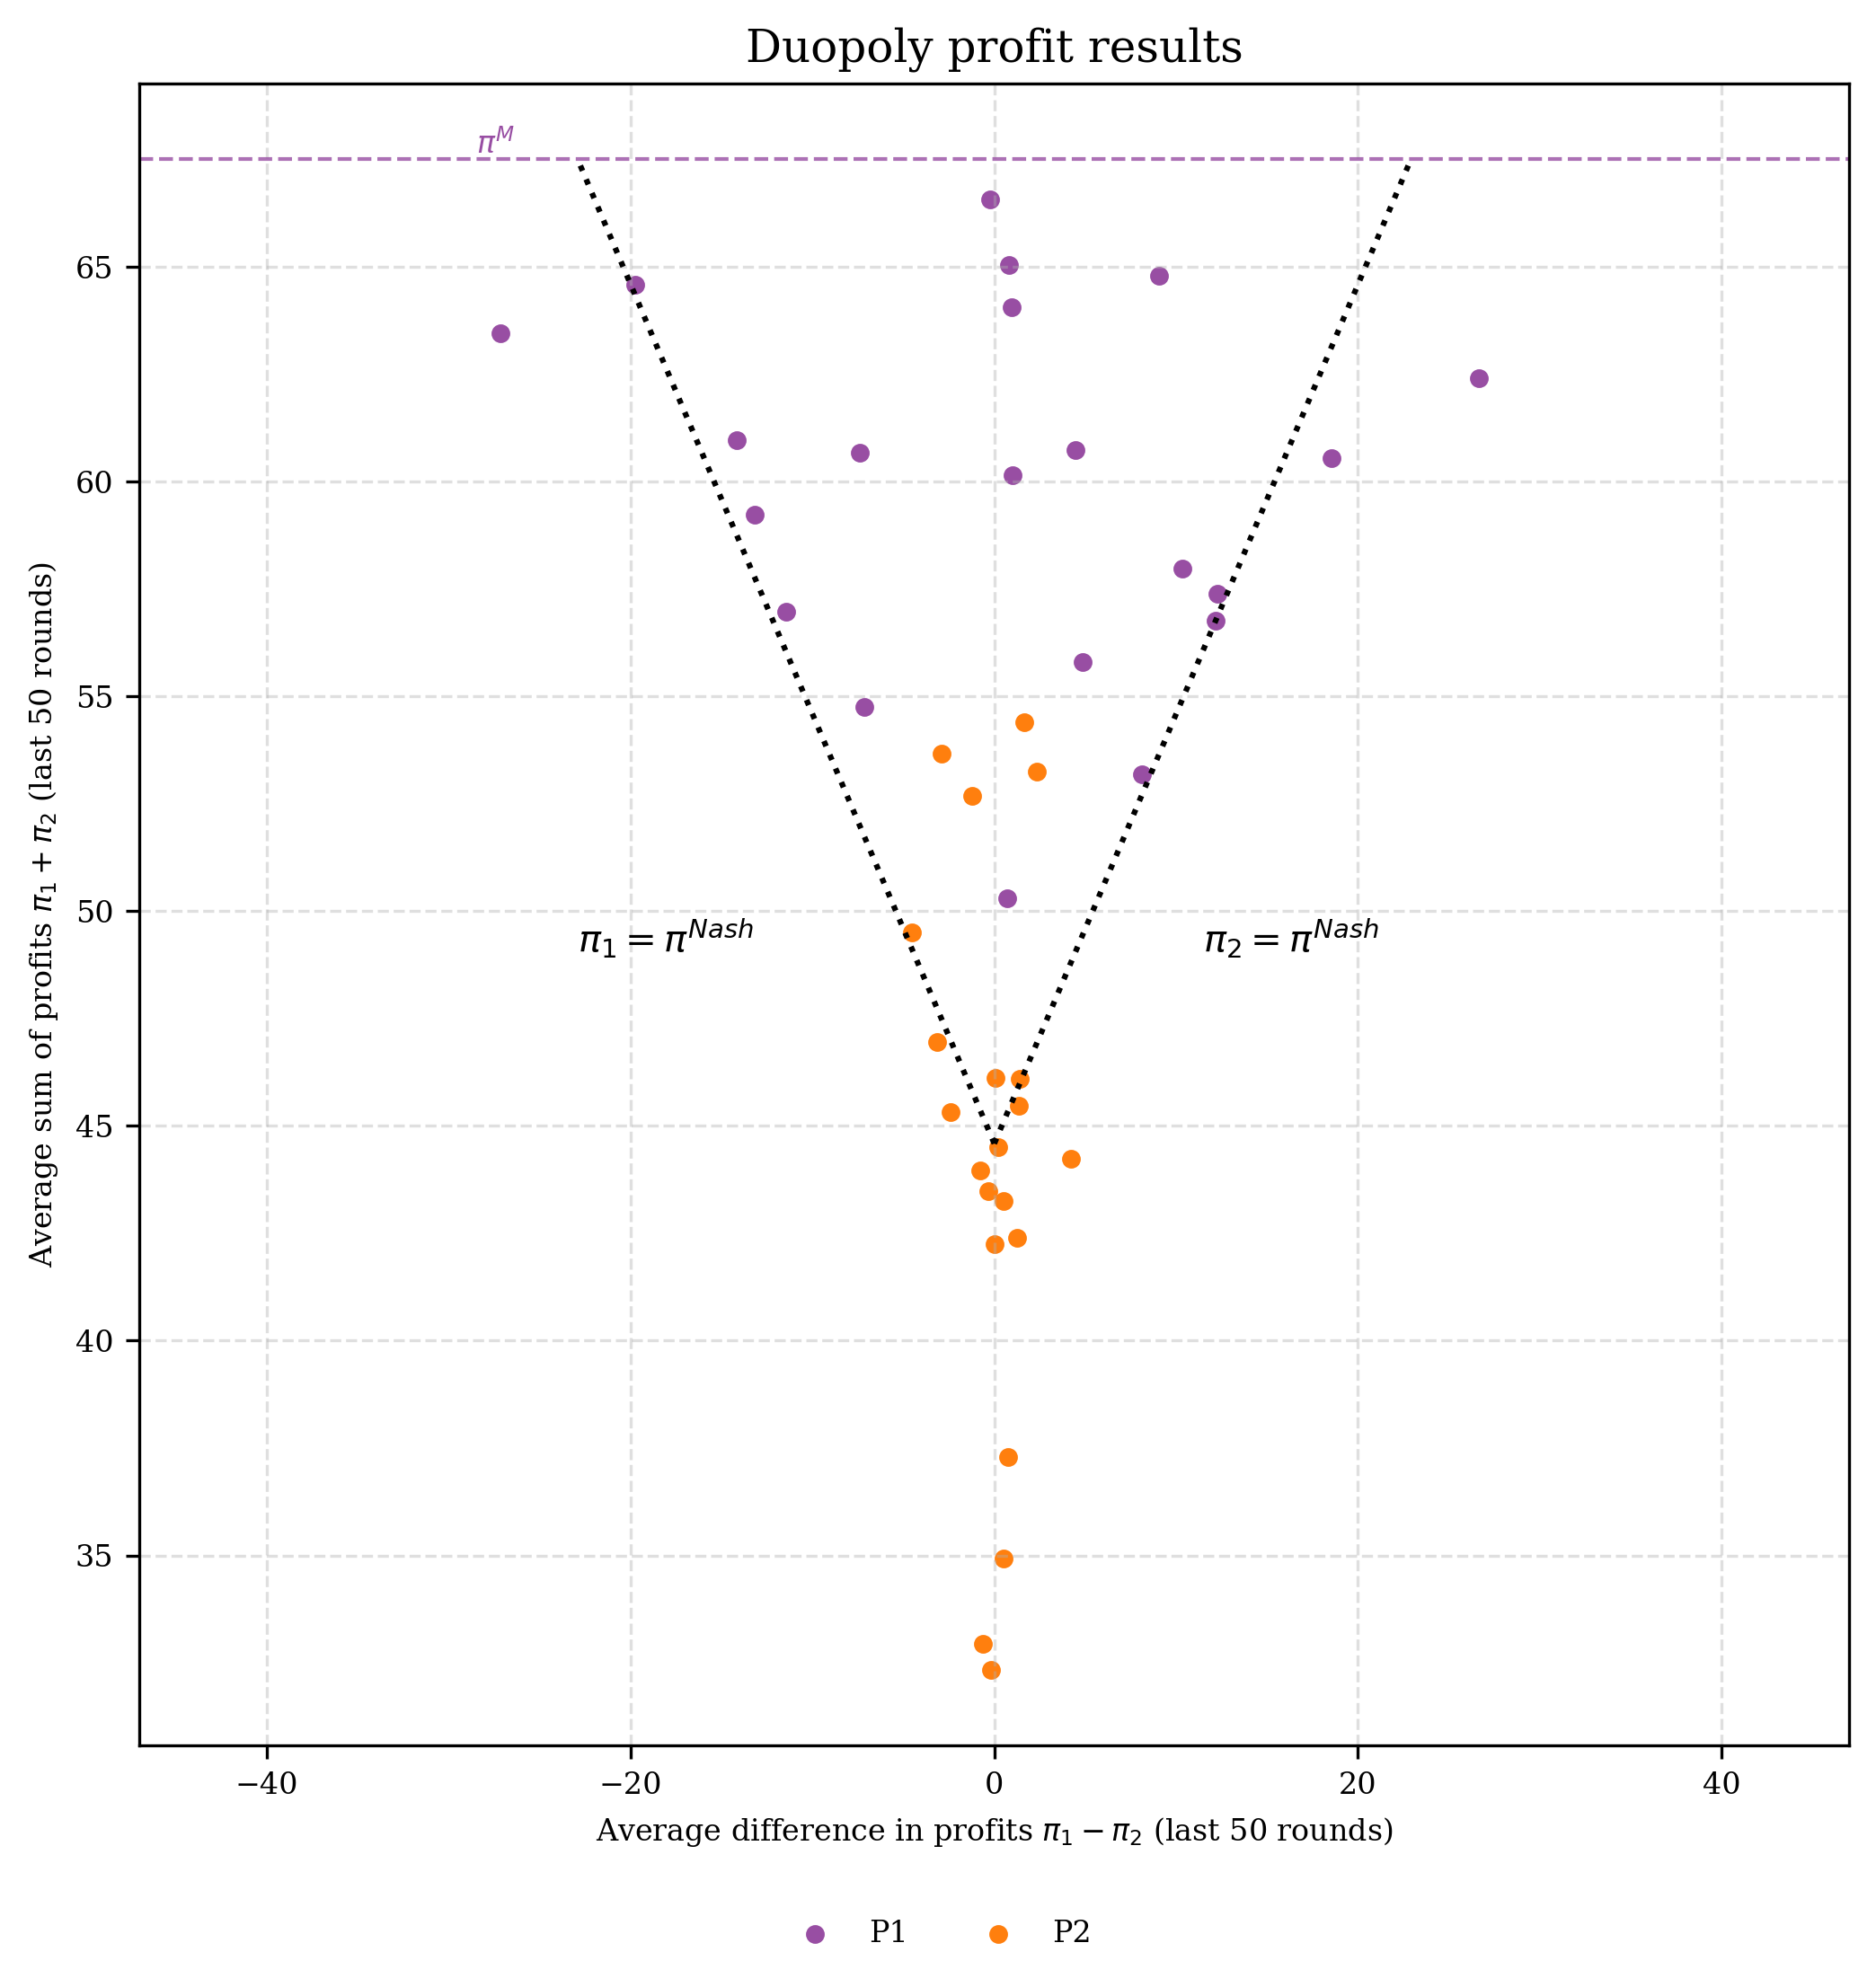

In [8]:
df_2 = df.filter(pl.col("num_agents") == 2)
plot_duopoly_profit_panel(
    df_2,
    pi_nash,
    pi_m,
    title="Duopoly profit results",
    save_path=DUOPOLY_OUPUT_PATH / "duopoly_profit_panel",
)

# ALL
___

In [9]:
df = pl.read_parquet(DATA_OUTPUT_PATH / "all_experiments.parquet").filter(
    (pl.col("num_agents") > 1) & (pl.col("is_symmetric"))
)
df = (
    df.filter(pl.col("round") > 255)
    .with_columns((pl.col("chosen_price") / pl.col("alpha")).alias("price_normalized"))
    .select(
        [
            "experiment_timestamp",
            "agent",
            "agent_prefix_type",
            "alpha",
            "chosen_price",
            "price_normalized",
            "profit",
            "num_agents",
        ]
    )
    .with_columns(
        [
            pl.when(pl.col("num_agents") == 2)
            .then(pl.lit("Duopoly"))
            .when(pl.col("num_agents") == 3)
            .then(pl.lit("Oligopoly (3)"))
            .when(pl.col("num_agents") == 4)
            .then(pl.lit("Oligopoly (4)"))
            .otherwise(pl.lit("Oligopoly (5)"))
            .alias("num_agents_type")
        ]
    )
    .group_by(
        ["experiment_timestamp", "agent_prefix_type", "num_agents_type", "num_agents"]
    )
    .agg(pl.col("price_normalized").mean().round(2).alias("price_normalized"))
    .sort(["num_agents", "agent_prefix_type"])
)
df.head()

experiment_timestamp,agent_prefix_type,num_agents_type,num_agents,price_normalized
str,str,str,i64,f64
"""1750988131""","""P1""","""Duopoly""",2,1.69
"""1751088827""","""P1""","""Duopoly""",2,2.05
"""1751052716""","""P1""","""Duopoly""",2,1.68
"""1751063127""","""P1""","""Duopoly""",2,1.67
"""1751040841""","""P1""","""Duopoly""",2,2.14


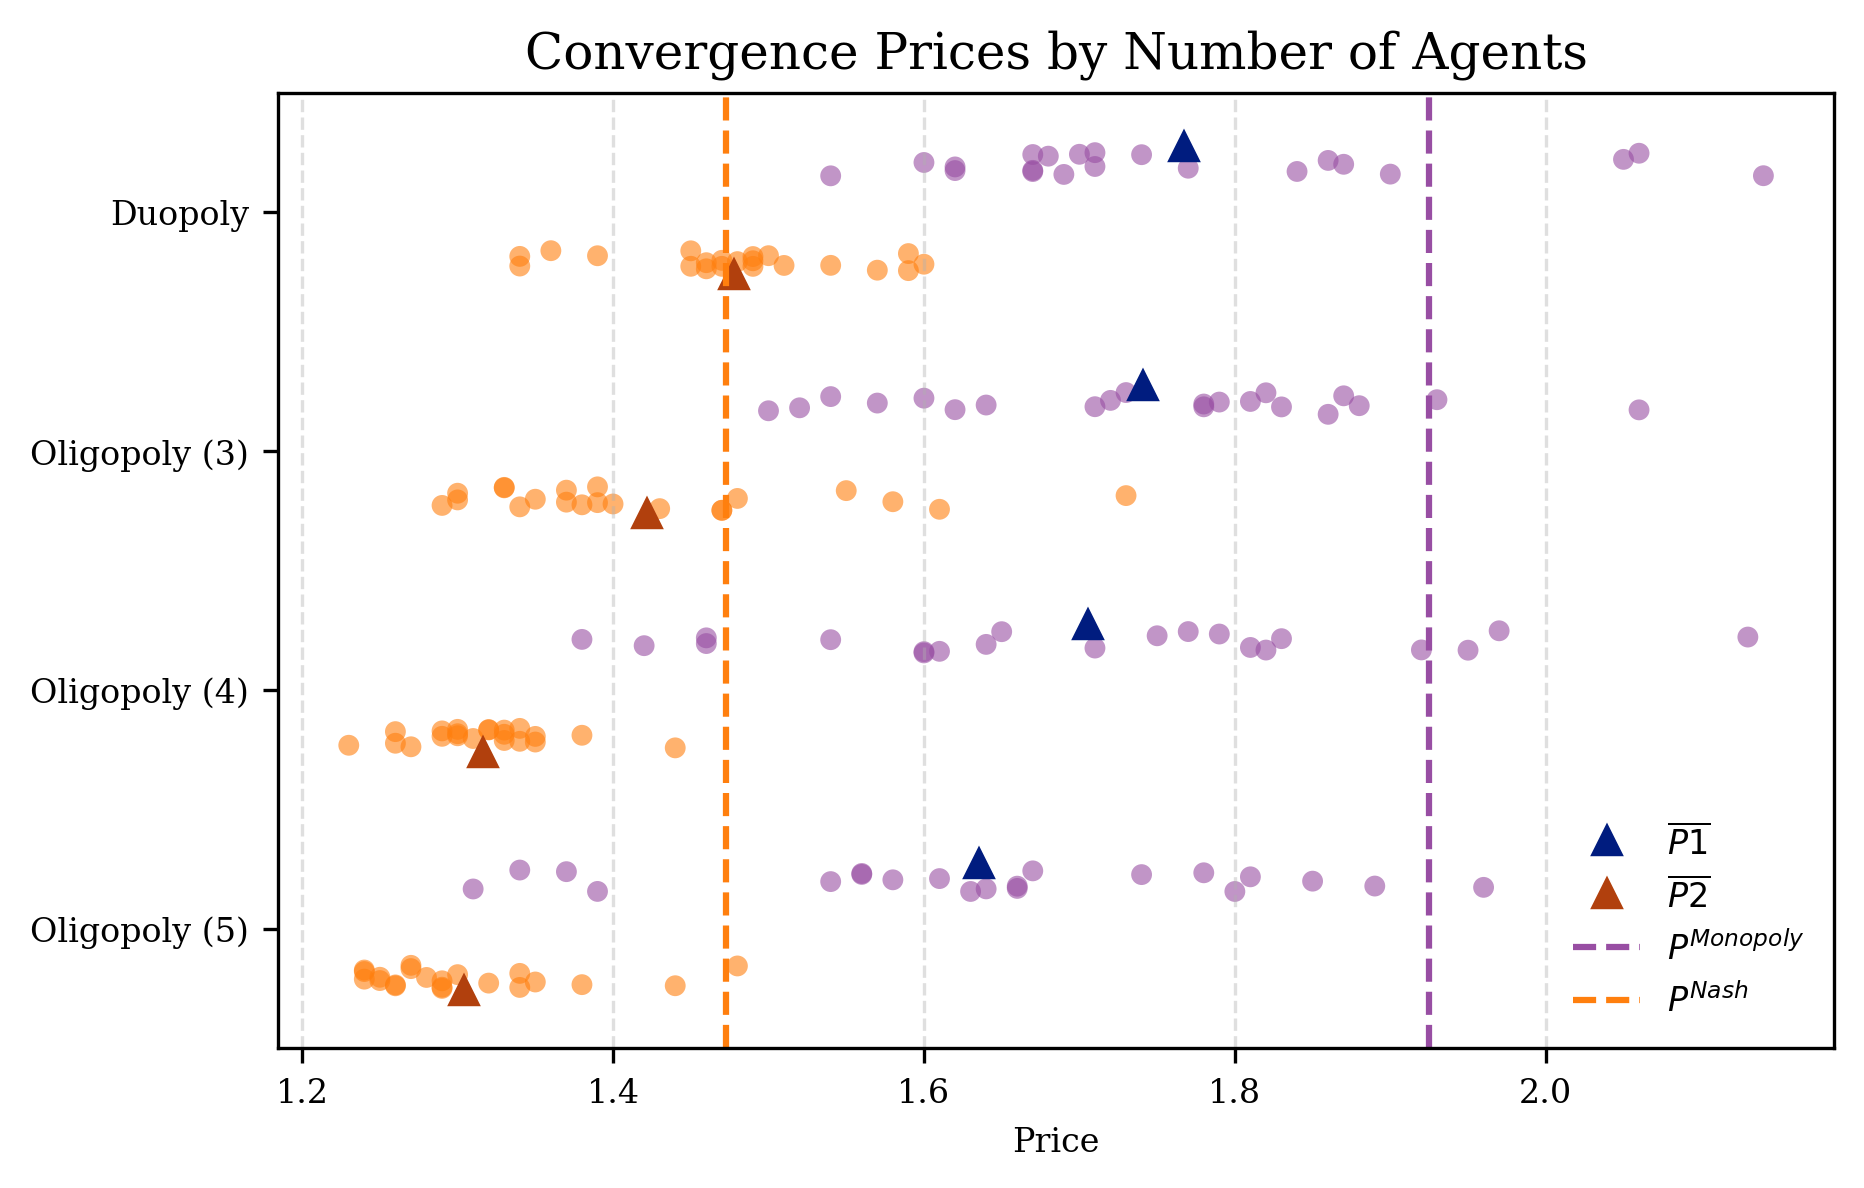

In [10]:
def plot_convergence_prices(
    df, p_m, p_nash, title="Convergence Prices by Number of Agents", save_path=None
):
    # Initialize the figure and axis
    fig, ax = plt.subplots()

    # Stripplot of last 50 mean prices
    sns.stripplot(
        data=df,
        x="price_normalized",
        y="num_agents_type",
        hue="agent_prefix_type",
        dodge=True,
        alpha=0.6,
        zorder=1,
        legend=False,
        ax=ax,
    )

    # Adjust agent_prefix_type labels for pointplot
    df = df.with_columns(
        (
            pl.when(pl.col("agent_prefix_type") == "P1")
            .then(pl.lit(r"$\overline{P1}$"))
            .otherwise(pl.lit(r"$\overline{P2}$"))
        ).alias("agent_prefix_type_label")
    )

    # Pointplot of conditional means
    sns.pointplot(
        data=df.to_pandas(),  # Seaborn often prefers pandas DataFrame, so convert if needed
        x="price_normalized",
        y="num_agents_type",
        hue="agent_prefix_type_label",
        dodge=0.8 - 0.8 / 3,
        palette="dark",
        errorbar=None,
        markers="^",
        markersize=5,
        linestyle="none",
        ax=ax,
    )

    # Vertical lines for p_m and p_nash
    ax.axvline(x=p_m, linestyle="--", label=r"$P^{Monopoly}$", color=colors[0])
    ax.axvline(x=p_nash, linestyle="--", label=r"$P^{Nash}$", color=colors[1])

    # Axis labels and title
    ax.set_ylabel("")
    ax.set_xlabel("Price")
    ax.set_title(title)

    # Legend
    ax.legend()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()


plot_convergence_prices(
    df,
    p_m,
    p_nash,
    title="Convergence Prices by Number of Agents",
    save_path=OUPUT_PATH / "convergence_prices_by_num_agents",
)

In [11]:
df = (
    pl.read_parquet(DATA_OUTPUT_PATH / "all_experiments.parquet")
    .filter((pl.col("num_agents") > 1) & (pl.col("is_symmetric")))
    .with_columns((pl.col("chosen_price") / pl.col("alpha")).alias("price_normalized"))
    .select(
        [
            "experiment_timestamp",
            "num_agents",
            "agent",
            "round",
            "agent_prefix_type",
            "price_normalized",
            "profit",
        ]
    )
    .sort(["experiment_timestamp", "agent", "round"])
)

df

experiment_timestamp,num_agents,agent,round,agent_prefix_type,price_normalized,profit
str,i64,str,i64,str,f64,f64
"""1750982396""",2,"""Firm A""",1,"""P1""",2.0,50.0
"""1750982396""",2,"""Firm A""",2,"""P1""",2.0,49.99
"""1750982396""",2,"""Firm A""",3,"""P1""",1.5,44.03
"""1750982396""",2,"""Firm A""",4,"""P1""",2.5,17.6
"""1750982396""",2,"""Firm A""",5,"""P1""",3.0,3.18
…,…,…,…,…,…,…
"""1751383759""",5,"""Firm E""",296,"""P1""",1.401,5.24
"""1751383759""",5,"""Firm E""",297,"""P1""",1.402,5.24
"""1751383759""",5,"""Firm E""",298,"""P1""",1.401,5.24


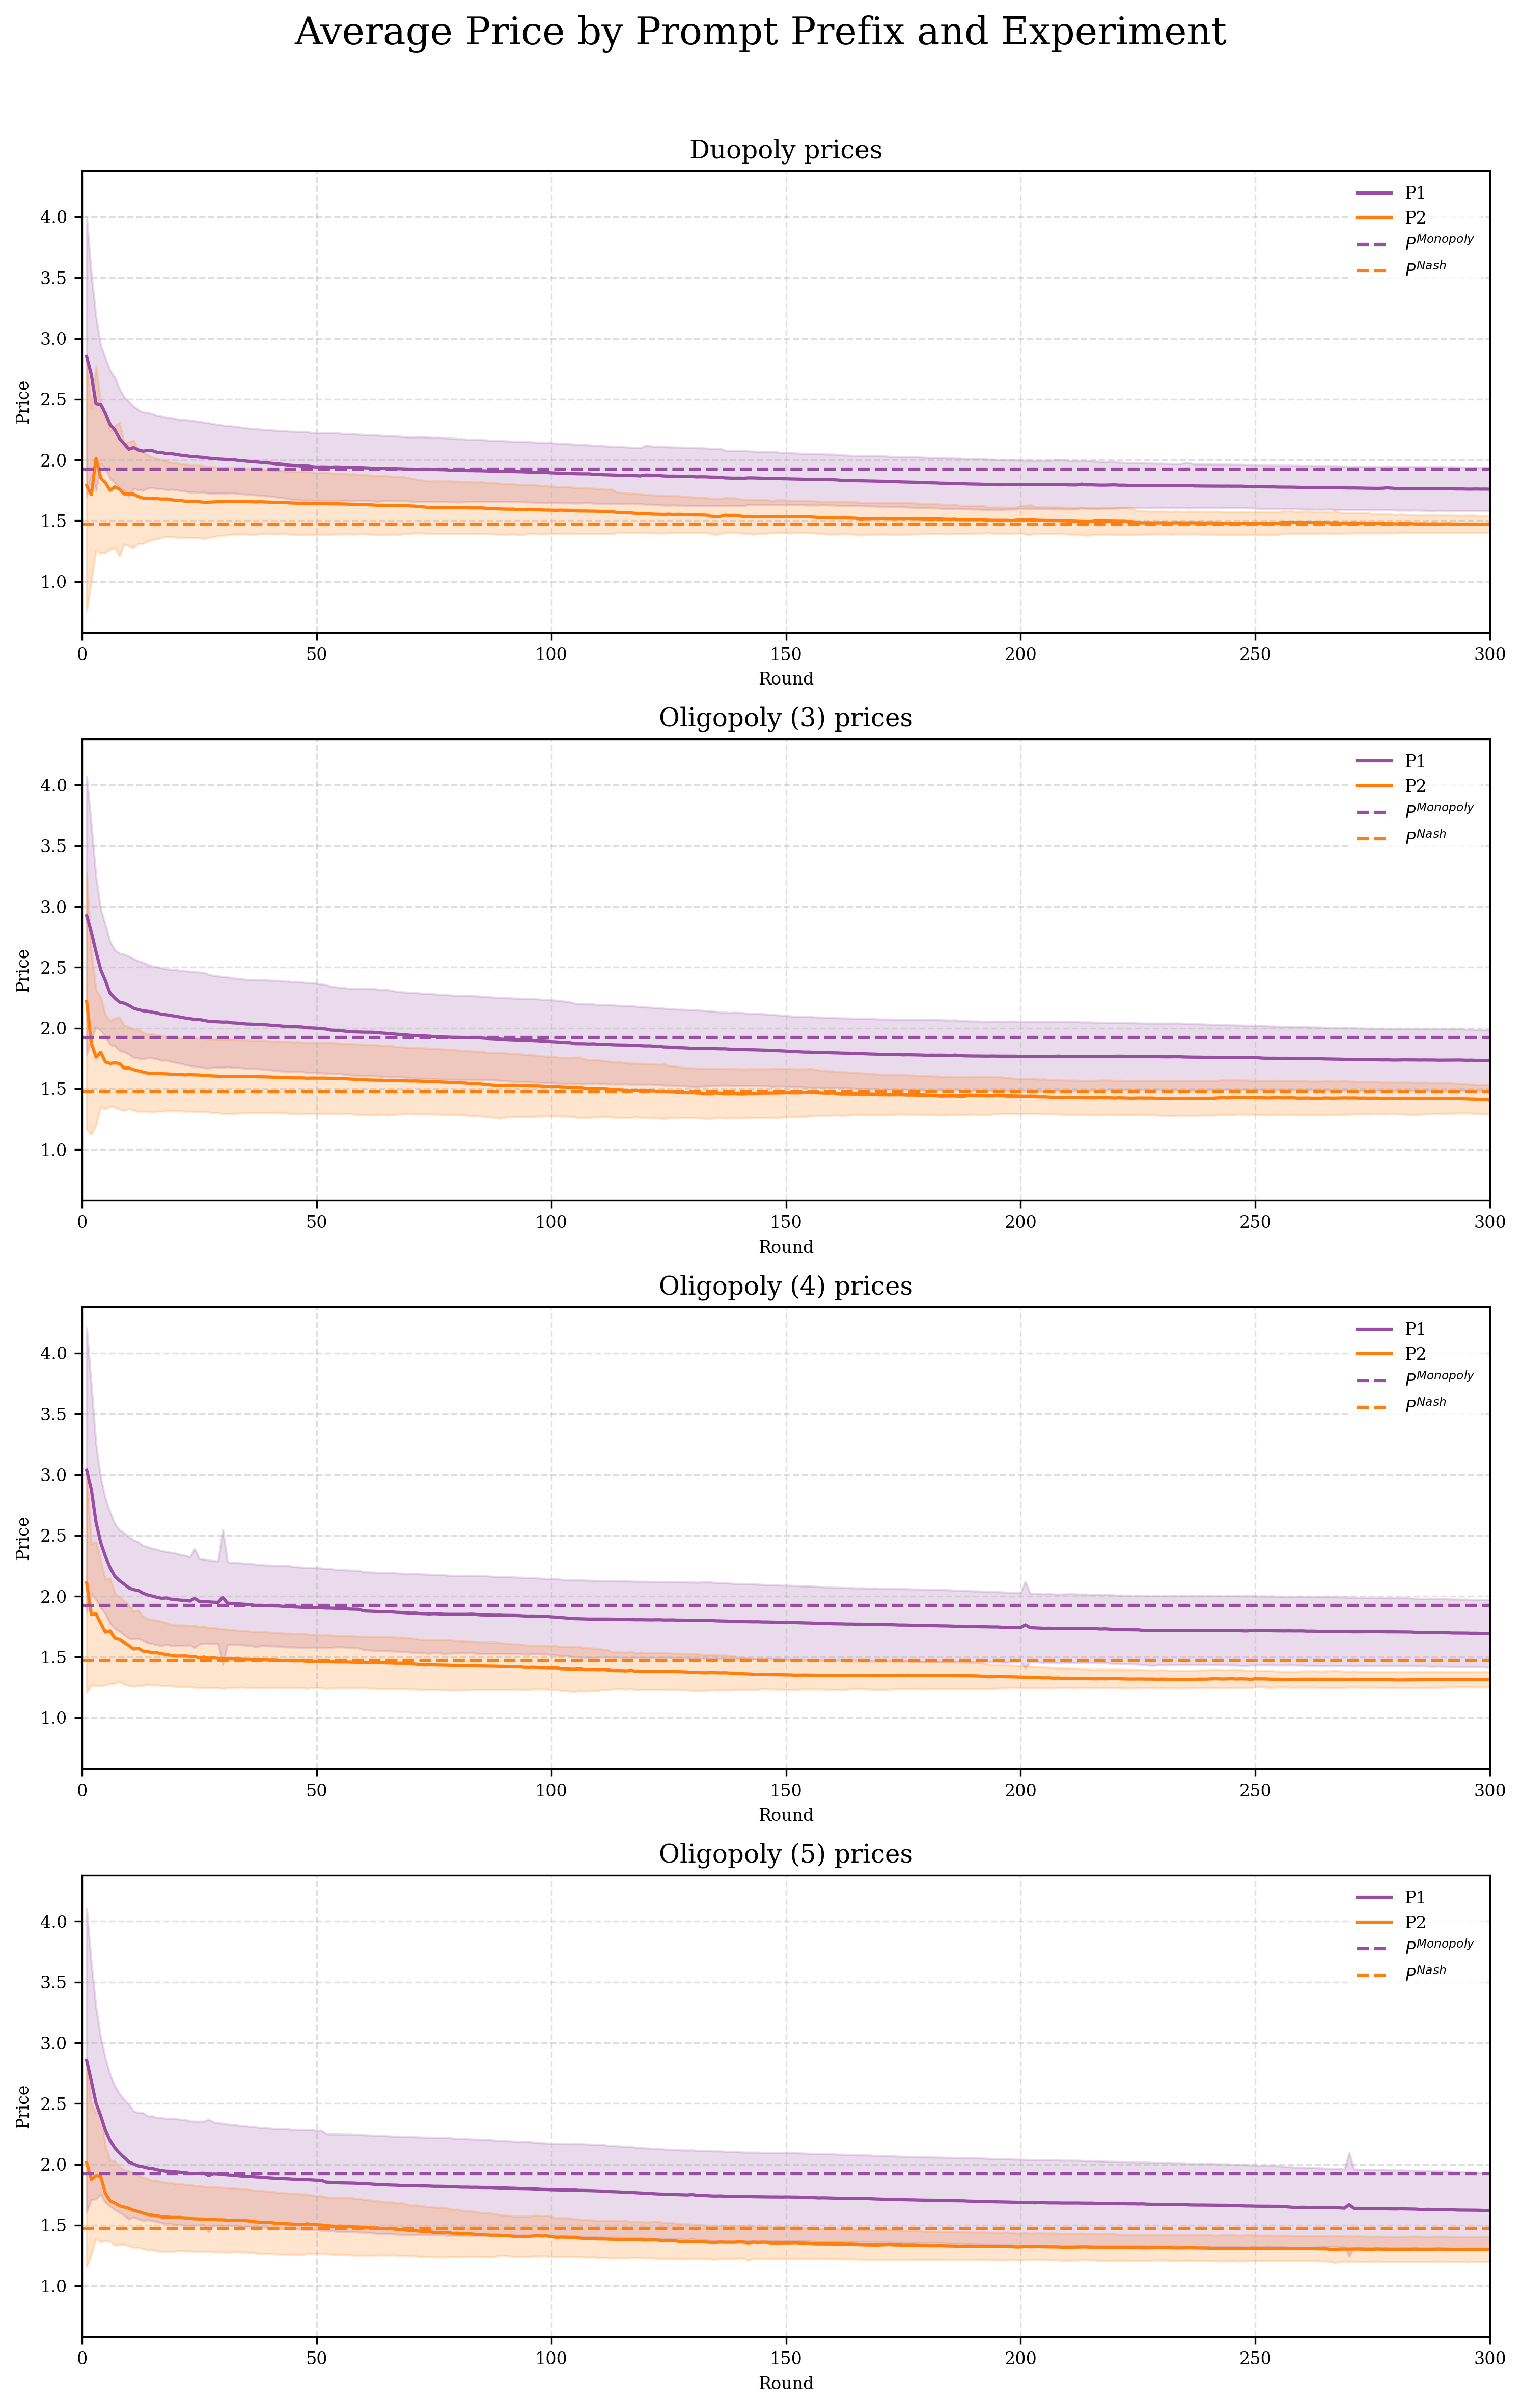

In [12]:
def plot_timeseries_price_subplots(df, p_m, p_nash, title, save_path=None):
    colors = sns.color_palette()  # get default color palette

    unique_agents = sorted(df["num_agents"].unique())
    fig, axs = plt.subplots(4, 1, figsize=(10, 16), sharex=False, sharey=True)

    subtitles = {
        2: "Duopoly",
        3: "Oligopoly (3)",
        4: "Oligopoly (4)",
        5: "Oligopoly (5)",
    }

    for i, num_agents in enumerate(unique_agents[:4]):  # First 4 num_agents
        ax = axs[i]
        subset = df.filter(pl.col("num_agents") == num_agents)

        sns.lineplot(
            data=subset,
            x="round",
            y="price_normalized",
            hue="agent_prefix_type",
            errorbar="sd",
            err_style="band",
            estimator="mean",
            ax=ax,
        )

        ax.set_title(f"{subtitles.get(num_agents, f'Num Agents: {num_agents}')} prices")
        ax.set_xlabel("Round")
        ax.set_ylabel("Price")
        ax.set_xlim(0, 300)

        # Add monopoly and nash horizontal lines
        ax.axhline(y=p_m, linestyle="--", label=r"$P^{Monopoly}$", color=colors[0])
        ax.axhline(y=p_nash, linestyle="--", label=r"$P^{Nash}$", color=colors[1])
        ax.legend()

    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()


plot_timeseries_price_subplots(
    df,
    p_m=p_m,
    p_nash=p_nash,
    title="Average Price by Prompt Prefix and Experiment",
    save_path=OUPUT_PATH / "price_over_time_by_prompt_prefix",
)